In [143]:
import math
import random
import os

import igraph as ig
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import collections  as mc
from wordcloud import WordCloud

import query2igraph as q2i
import plotgraph as pg

from IPython.utils.text import columnize

In [144]:
path = "../packages/issi_data_package/output_files/data/"
queryID = "774e7eb6-6ac7-4dd5-9339-531b746cb8ec"

graph = q2i.query2igraph(queryID,path=path)

print("Number of vertices: %d"%graph.vcount())
print("Number of edges: %d"%graph.ecount())
print("Average degree: %.2f"%(graph.ecount()/graph.vcount()))

Number of vertices: 6852
Number of edges: 36704
Average degree: 5.36


In [145]:
print(columnize(graph.vertex_attributes()))

paper_id  original_title        journal_display_name
year      authors_display_name  paper_abstract      



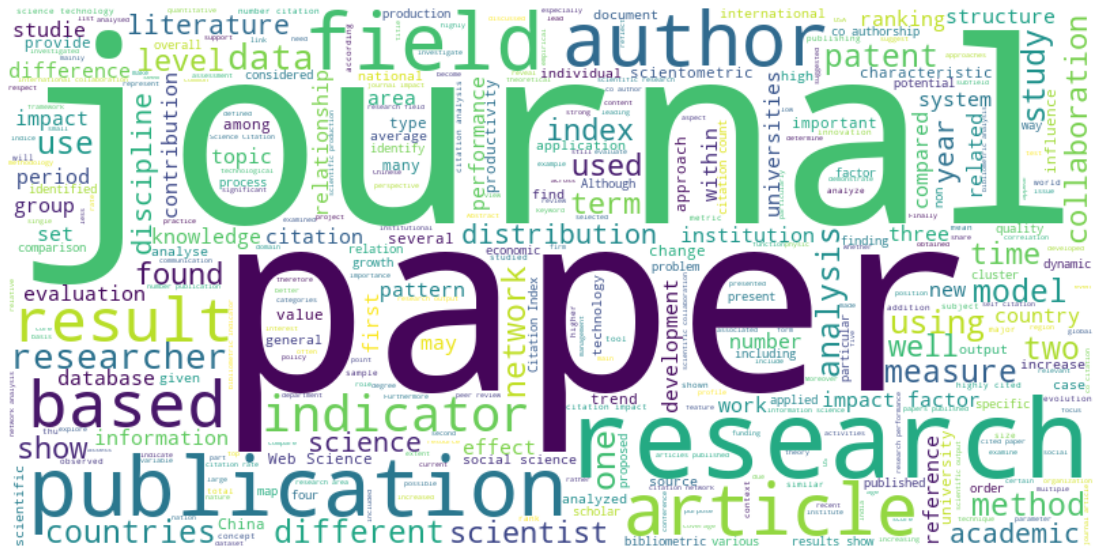

In [146]:
# Word Cloud for Abstracts
wc = WordCloud(background_color="white", max_words=2000, width=800,height=400, scale=1,contour_width=3, contour_color='white')
plt.figure(figsize=(20,10))
wc.generate("\n".join(graph.vs["paper_abstract"]))
plt.imshow(wc, interpolation='bilinear')
plt.axis("off")
plt.show()

In [147]:
# Calculating KCore and getting year
graph.vs["KCore"] = graph.shell_index(mode="IN")

print("Data from %d to %d"%(min(graph.vs["year"]),max(graph.vs["year"])))

Data from 1976 to 2019


In [149]:
# Obtaining giant weakly connected component
giant = graph.clusters(mode="WEAK").giant()

print("In the giant component:")
print("\tNumber of vertices: %d"%giant.vcount())
print("\tNumber of edges: %d"%giant.ecount())
print("\tAverage degree: %.2f"%(giant.ecount()/giant.vcount()))

In the giant component:
	Number of vertices: 6072
	Number of edges: 36687
	Average degree: 6.04


In [166]:
# Obtaining communities
giantCopy = giant.copy()
giantCopy.to_undirected() #Using Louvain, so the network needs to be undirected
giant.vs["Community"] = [str(c) for c in giantCopy.community_multilevel().membership]
print("Number of communities: %d"%len(set(giant.vs["Community"])))

Number of communities: 18


In [167]:
# Saving network
import xnet as xn
os.makedirs("../networks", exist_ok=True)
xn.igraph2xnet(giant,"../networks/%s.xnet"%queryID);

In [151]:
# Filter graph by year and KCore

minYear = 2000
minKCore = 1

filteredGraph = giant.copy()

beforeMinYear = np.array(filteredGraph.vs["year"])<minYear
lessThanMinKCore = np.array(filteredGraph.vs["KCore"])<minKCore

verticesToDelete = np.where(np.logical_or(beforeMinYear,lessThanMinKCore))[0]
filteredGraph.delete_vertices(verticesToDelete)
filteredGraph = filteredGraph.clusters(mode="WEAK").giant() #gets the major component again just in case

print("Filtered graph:")
print("\tNumber of vertices: %d"%filteredGraph.vcount())
print("\tNumber of edges: %d"%filteredGraph.ecount())
print("\tAverage degree: %.2f"%(filteredGraph.ecount()/filteredGraph.vcount()))

Filtered graph:
	Number of vertices: 1780
	Number of edges: 8824
	Average degree: 4.96


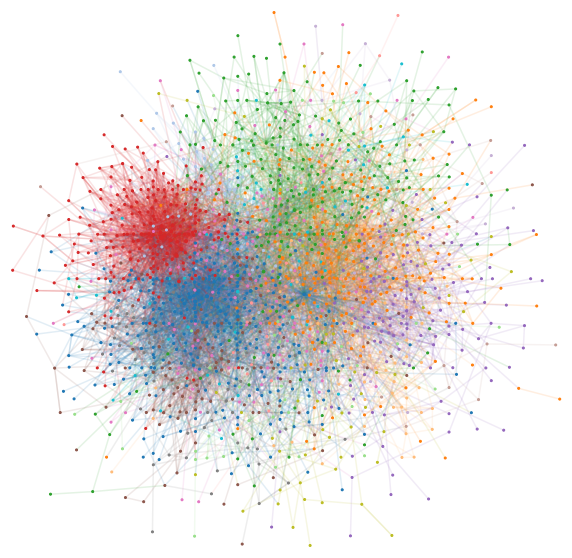

In [152]:
# Visualization

fig, ax = plt.subplots(figsize=(10,10))
pg.drawGraph(filteredGraph,ax)
plt.axis("off")
plt.show()

In [157]:
# Word Cloud for communities

maxInternalWords = 300
maxAllWords = 1000
maxCommunities = 4;

# Color styles
_styleColors = ["#1f77b4","#ff7f0e","#2ca02c","#d62728","#9467bd",
                "#8c564b","#e377c2","#7f7f7f","#bcbd22","#17becf",
                "#aec7e8","#ffbb78","#98df8a","#ff9896","#c5b0d5",
                "#c49c94","#f7b6d2","#c7c7c7","#dbdb8d","#9edae5"]

# Some auxiliary functions
def sortByFrequency(arr):
    s = set(arr)
    keys = {n: (-arr.count(n), arr.index(n)) for n in s}
    return sorted(list(s), key=lambda n: keys[n])

def lighten_color(color, amount=0.5):
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])


def generateColorFunction(originalColor):
    def lighten_color_func(word, font_size, position, orientation, random_state=None,**kwargs):
        c = lighten_color(originalColor,font_size/200*0.6+0.2+0.4*random.random())
        return (int(c[0]*255),int(c[1]*255),int(c[2]*255))
    return lighten_color_func

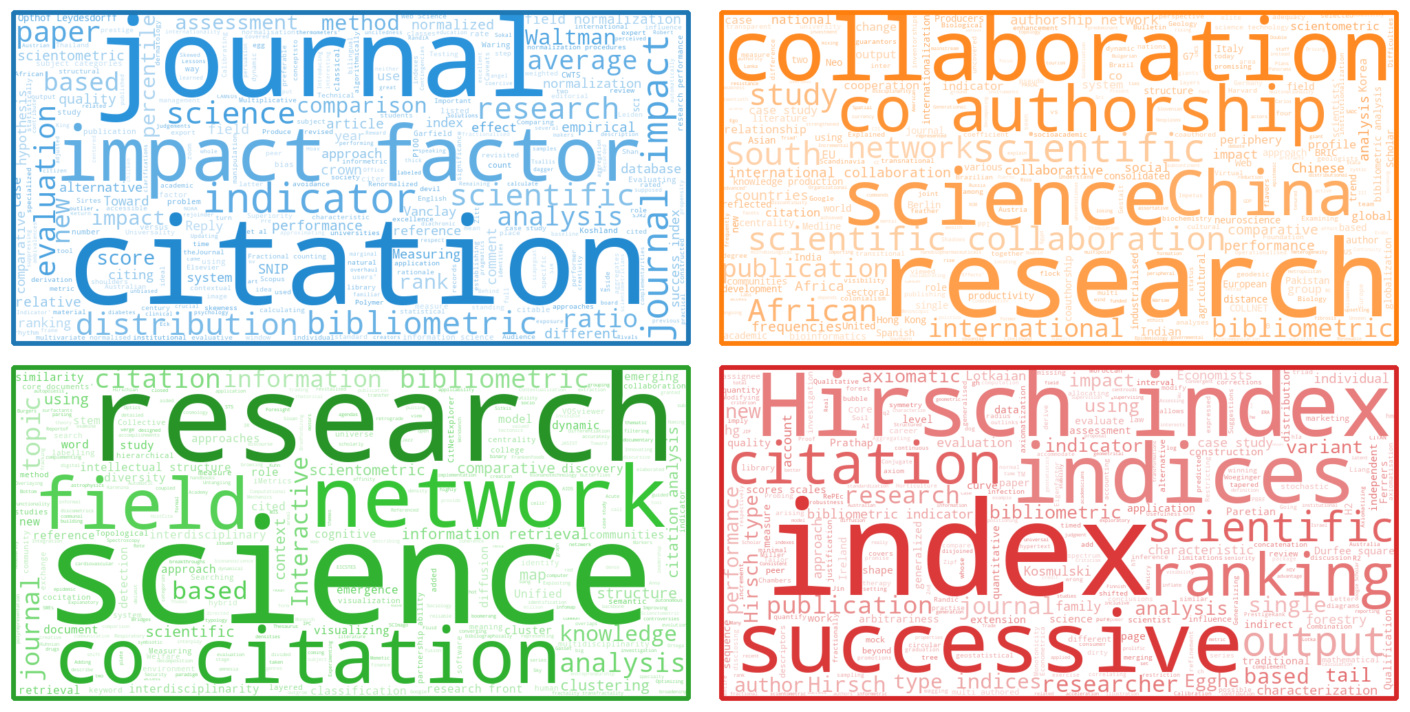

In [158]:
# Creating 
wordcloudProperty = "original_title" # "paper_abstract"

communities = filteredGraph.vs["Community"]
sortedCommunities = sortByFrequency(communities)[0:maxCommunities]
fig = plt.figure(figsize=(20,5*math.ceil(len(sortedCommunities)/2)))
allAbstracts = "\n".join(filteredGraph.vs[wordcloudProperty])
allFrequencies = WordCloud(max_words=maxAllWords).process_text(allAbstracts)
amask = np.zeros((500,1000),dtype='B')
amask[:10,:] = 255
amask[-10:,:] = 255
amask[:,:10] = 255
amask[:,-10:] = 255
for index,community in enumerate(sortedCommunities):
    communityColor = (_styleColors[index] if index<len(_styleColors) else "#aaaaaa")
    abstracts = "\n".join([vertex[wordcloudProperty] for vertex in filteredGraph.vs if vertex["Community"]==community])
    plt.subplot(math.ceil(len(sortedCommunities)/2),2,index+1)
    wc = WordCloud(background_color="white", max_words=maxInternalWords, width=1000,height=500,
        mask=amask,contour_width=10, contour_color=communityColor,random_state=3,color_func=generateColorFunction(communityColor))

    inCommunityFrequency = wc.process_text(abstracts)
    relativeFrequencies = {key:frequency/math.log(allFrequencies[key]+1) for key,frequency in inCommunityFrequency.items() if key in allFrequencies}
    wc.generate_from_frequencies(relativeFrequencies)

    plt.imshow(wc, interpolation='bilinear')
    plt.axis("off")

plt.tight_layout()
plt.show()